<a href="https://colab.research.google.com/github/NishatVasker/CSE475_MACHINE_LEARNING/blob/main/human_activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pafy youtube-dl moviepy


In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
%%capture
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar



In [ ]:
!unrar x UCF50.rar


/bin/bash: line 1: unrar: command not found


In [ ]:

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

inputdir = '/kaggle/input/realistic-action-recognition-ucf50/UCF50'
all_classes_names = os.listdir(inputdir)

In [ ]:
all_classes_names

['HorseRace',
 'VolleyballSpiking',
 'Biking',
 'TaiChi',
 'Punch',
 'BreastStroke',
 'Billiards',
 'PoleVault',
 'ThrowDiscus',
 'BaseballPitch',
 'HorseRiding',
 'Mixing',
 'HighJump',
 'Skijet',
 'SkateBoarding',
 'MilitaryParade',
 'Fencing',
 'JugglingBalls',
 'Swing',
 'RockClimbingIndoor',
 'SalsaSpin',
 'PlayingTabla',
 'Rowing',
 'BenchPress',
 'PushUps',
 'Nunchucks',
 'PlayingViolin',
 'PullUps',
 'PlayingPiano',
 'HulaHoop',
 'RopeClimbing',
 'YoYo',
 'TrampolineJumping',
 'JumpingJack',
 'Drumming',
 'GolfSwing',
 'PlayingGuitar',
 'PizzaTossing',
 'Lunges',
 'TennisSwing',
 'WalkingWithDog',
 'Kayaking',
 'PommelHorse',
 'Basketball',
 'JumpRope',
 'CleanAndJerk',
 'Skiing',
 'Diving',
 'SoccerJuggling',
 'JavelinThrow']

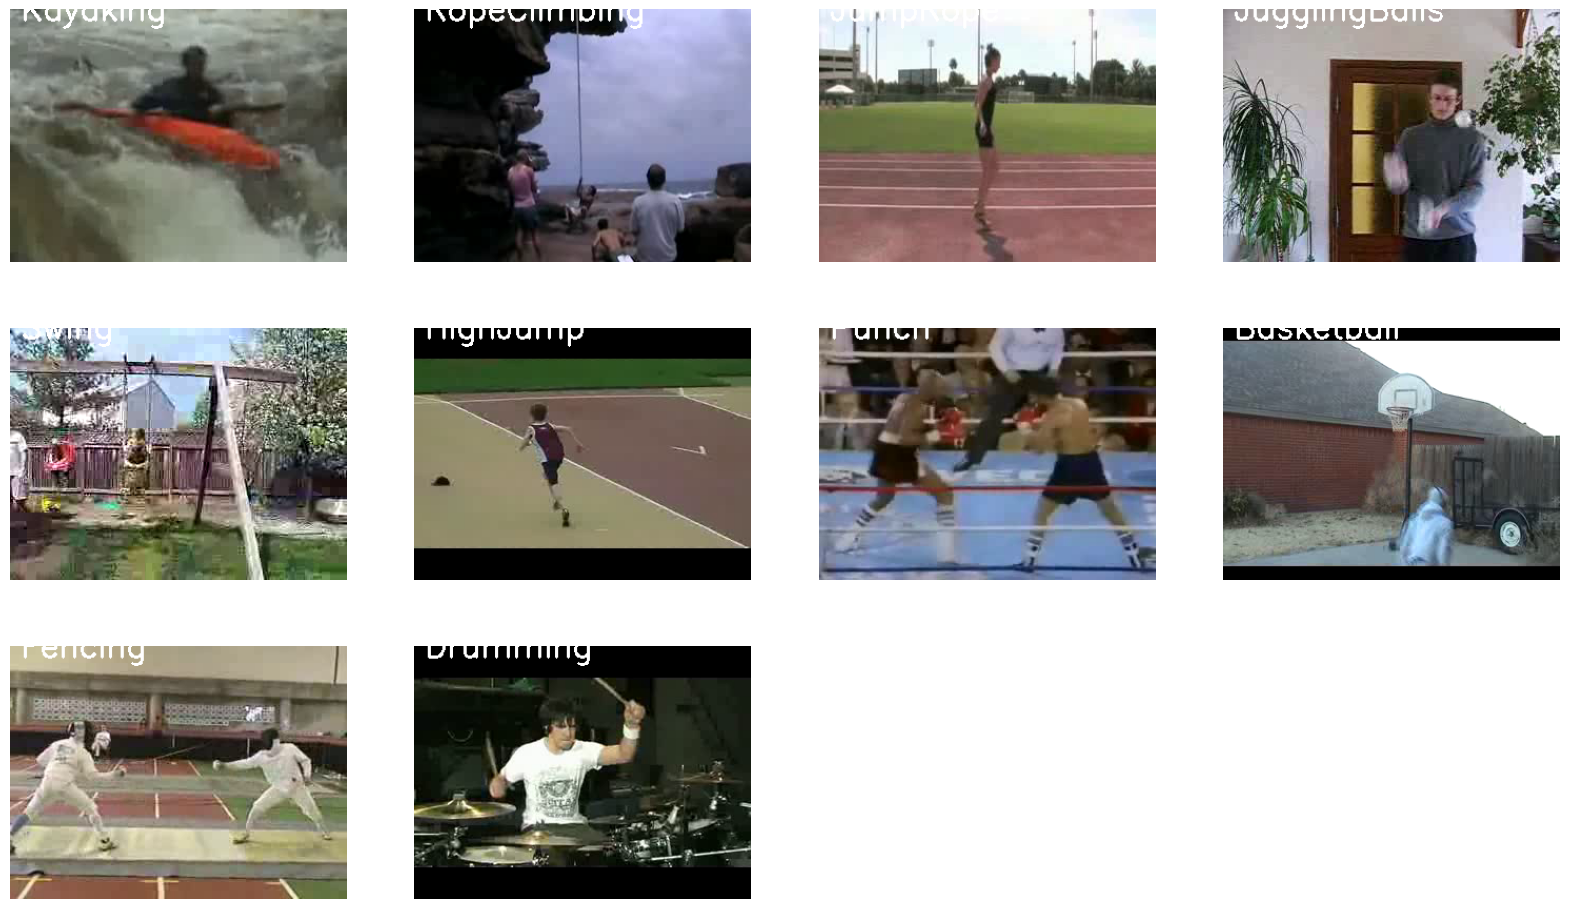

In [ ]:
plt.figure(figsize = (20,20))
random_range = random.sample(range(len(all_classes_names)), 10)

for counter,random_index in enumerate(random_range,1):
    selected_class_name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'{inputdir}/{selected_class_name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'{inputdir}/{selected_class_name}/{selected_video_file_name}')
    _,bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_name, (10,10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    plt.subplot(5,4,counter);plt.imshow(rgb_frame);plt.axis('off')




In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64,64
SEQUENCE_LENGTH = 20
CLASS_LIST = ["Diving", "Punch", "PushUps"]


In [ ]:
def frame_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frame_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

In [ ]:
 def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASS_LIST):
        print(f'Extracting data of class: {class_name}')

        files_list = os.listdir(os.path.join(inputdir, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(inputdir, class_name, file_name)
            frames = frame_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()


Extracting data of class: Diving
Extracting data of class: Punch
Extracting data of class: PushUps


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
feature_train, feature_test, label_train, label_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense


def create_convlstm_model():
    model = Sequential()

    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True,
                         input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(Flatten())

    model.add(Dense(len(CLASS_LIST), activation="softmax"))

    # Display the model summary
    model.summary()
    return model

In [ ]:
convlstm_model = create_convlstm_model()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_24 (ConvLSTM2D)     │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_24 (MaxPooling3D) │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_25 (ConvLSTM2D)     │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_25 (MaxPooling3D) │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_26 (ConvLSTM2D)     │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_26 (MaxPooling3D) │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_27 (ConvLSTM2D)     │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_27 (MaxPooling3D) │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         8,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,643 (162.67 KB)

 Trainable params: 41,643 (162.67 KB)

 Non-trainable params: 0 (0.00 B)

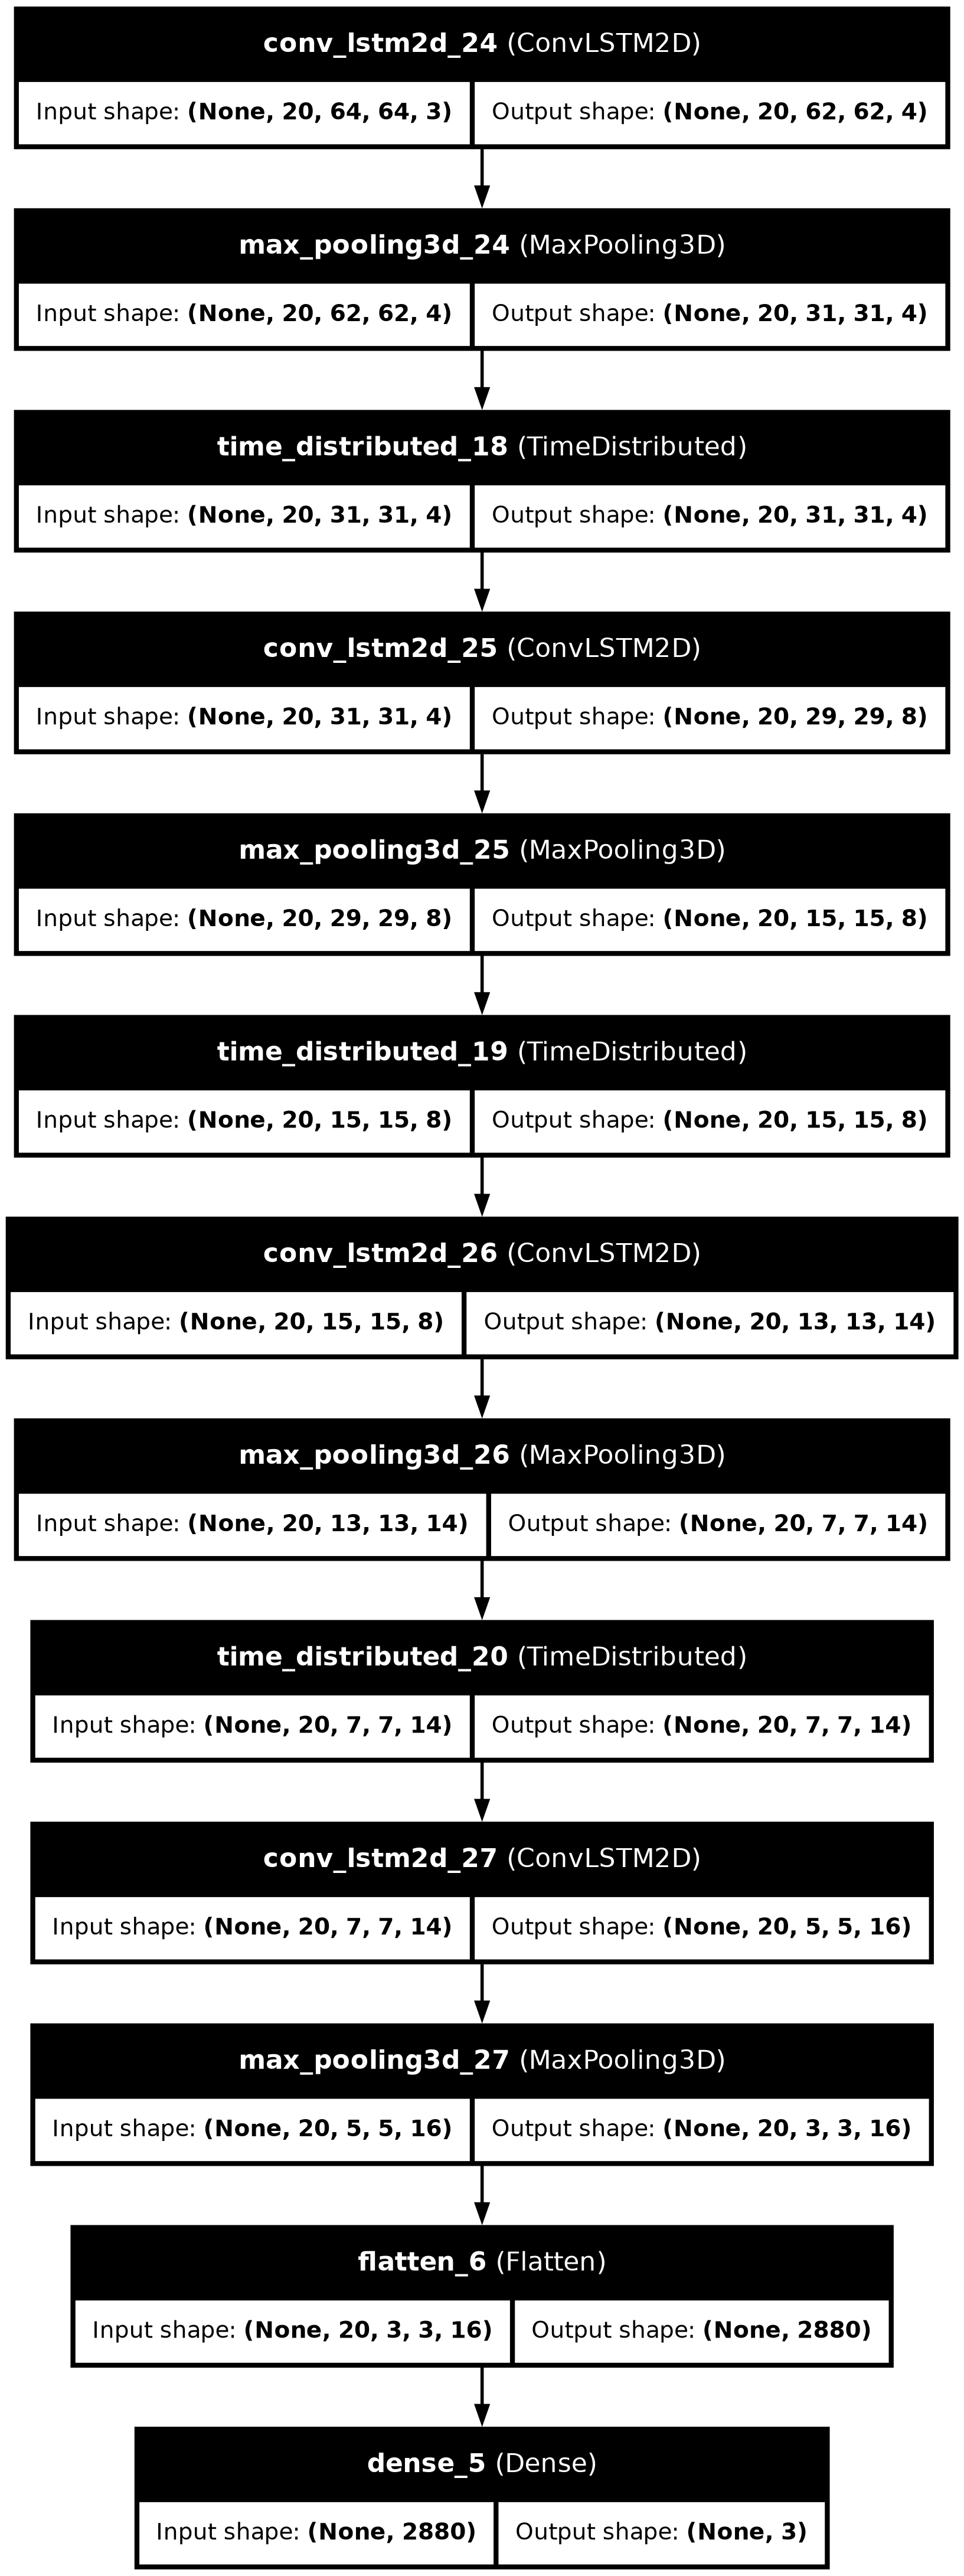

In [ ]:
plot_model(convlstm_model, show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
convlstm_model_training_history = convlstm_model.fit(x = feature_train, y = label_train, epochs = 50, batch_size = 4, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50


I0000 00:00:1727761299.315955    5706 service.cc:145] XLA service 0x585900a451c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727761299.316018    5706 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727761299.316024    5706 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1727761415.980124    5706 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 104 bytes spill stores, 104 bytes spill loads

I0000 00:00:1727761416.072766    5706 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4041 - loss: 1.0830

I0000 00:00:1727761532.305723    5706 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_1', 104 bytes spill stores, 104 bytes spill loads



63/63 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.4079 - loss: 1.0807 - val_accuracy: 0.6508 - val_loss: 0.7813
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6308 - loss: 0.7931 - val_accuracy: 0.6825 - val_loss: 0.8478
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7214 - loss: 0.7379 - val_accuracy: 0.8095 - val_loss: 0.5485
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7748 - loss: 0.5738 - val_accuracy: 0.9206 - val_loss: 0.4175
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8474 - loss: 0.4280 - val_accuracy: 0.8889 - val_loss: 0.3687
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8846 - loss: 0.3144 - val_accuracy: 0.9206 - val_loss: 0.2863
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9343 - loss: 0.1984 - val_accuracy: 0.9365 - val_loss: 0.2576
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9762 - loss: 0.1026 - val_accuracy: 0.9365 - val_loss: 0.

In [ ]:
model_evaluation_history = convlstm_model.evaluate(feature_test, label_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - accuracy: 0.8203 - loss: 0.6316


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

convlstm_model.save("humanactivity_recognition.h5")

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))
    plt.legend()

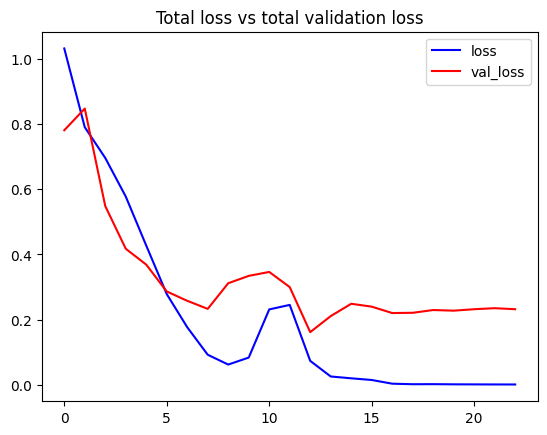

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total loss vs total validation loss')


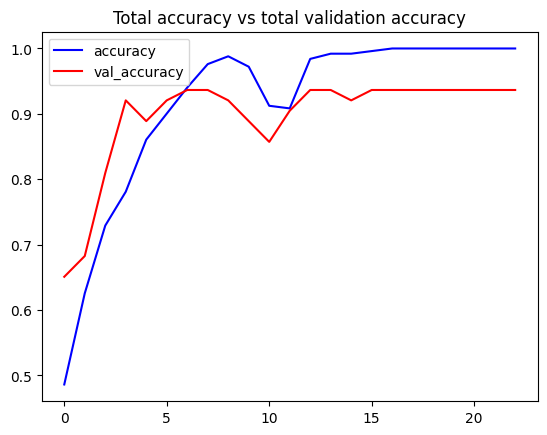

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total accuracy vs total validation accuracy')

In [ ]:
def create_LRCN_model():
    model = Sequential()

    # Define the Model Architecture.
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    # Adding an LSTM layer with 32 units.
    model.add(LSTM(32))

    # Output layer with softmax activation for classification
    model.add(Dense(len(CLASS_LIST), activation="softmax"))

    # Display the model summary
    model.summary()

    # Return the constructed LRCN model.
    return model



In [ ]:
LRCN_model = create_LRCN_model()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_21             │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,027 (285.26 KB)

 Trainable params: 73,027 (285.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
LRCN_model_training_history = convlstm_model.fit(x = feature_train, y = label_train, epochs = 70, batch_size = 4, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.9365 - val_loss: 0.2064
Epoch 2/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9365 - val_loss: 0.2694
Epoch 3/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.9048 - val_loss: 0.3131
Epoch 4/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9750 - loss: 0.0624 - val_accuracy: 0.7143 - val_loss: 0.9042
Epoch 5/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8183 - loss: 0.5716 - val_accuracy: 0.9206 - val_loss: 0.2306
Epoch 6/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9850 - loss: 0.0653 - val_accuracy: 0.9365 - val_loss: 0.1572
Epoch 7/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.9683 - val_loss: 0.1524
Epoch 8/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.9206 - v

In [ ]:
LRCN_model_evaluation_history = LRCN_model.evaluate(feature_test, label_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3867 - loss: 1.0996


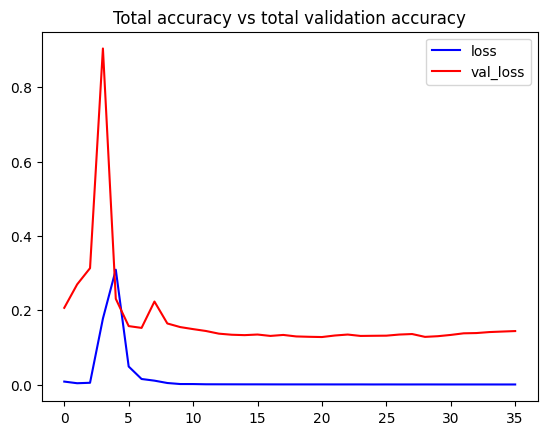

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total accuracy vs total validation accuracy')

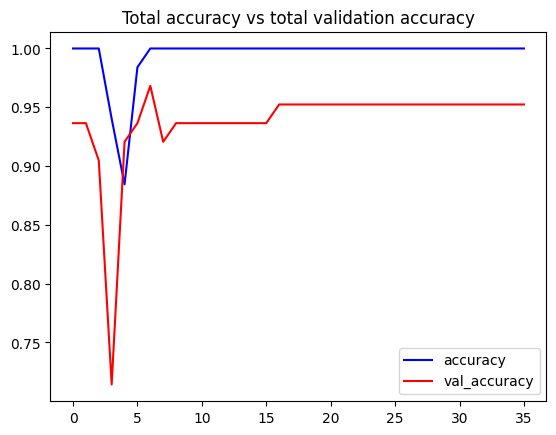

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total accuracy vs total validation accuracy')